<!--

Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

-->

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/medlm-embedding-cxr/raw/main/intro_notebook.ipynb">
      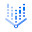
      Run in Vertex AI Workbench
    </a>
    </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/medlm-embedding-cxr/blob/main/intro_notebook.ipynb">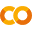
    Run in Colab
    </a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/medlm-embedding-cxr/">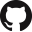
    View on GitHub
    </a>
  </td>
</table>

# Google Cloud MedLM Embedding API For CXR

This notebook will ingest labeled datasets derived from a clincial imaging (PACS, VNA) system and store them in Google Cloud Healthcare API. In turn, a pre-defined cohort definition will be used to retrieve the relevant labeled images, train using embeddings created with the CXR foundation model, and ultimately deploy and test a trained model on staged data.

If leveraging the sample data that is provided with the notebook, these datasets are from the [NIH Chest X-ray dataset](https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest). Additionally, DICOM KOS were created to go along with the sample images.  

### Prerequisites

- Make sure you have been granted access to the MedLM Embedding API For CXR by filling out [this](https://docs.google.com/forms/d/e/1FAIpQLSd-fBqL-Ox5Qqmr6Q7nRo2oTfbttgdr700-XjSV4GEKYhbicg/viewform) form.
- After you've been given access to the API, you only have to change the `PROJECT_ID` value below to your own project, and then you can Run All cells.
- Code was tested with Python v3.10.6 in VSCode, Vertex AI Workbench, and Colab

In [ ]:
import random, sys, time, os
import google.auth
# Used if you run the notebook multiple times
RAND = random.randint(1, 100000)

# You must update the variables in this section
PROJECT_ID = '[CHANGEME]'  # @param {type: 'string'}
credentials, user = google.auth.default()
print(f'User: {user}')
# Local and shell consts
os.environ['PROJECT_ID'] = PROJECT_ID
os.environ['LOCATION'] = LOCATION = (
    'us-central1'  # This region required for early access.
)
os.environ['DATASET_ID'] = DATASET_ID = 'cxr-experimental-dataset'
os.environ['STORE_ID'] = STORE_ID = 'cxr-experimental-dicom-store'
os.environ["BQ_TABLE_ID"] = BQ_TABLE_ID = "metadata"
os.environ['VERTEX_ENDPOINT_ID'] = VERTEX_ENDPOINT_ID = f'{user}-medlm-cxr-endpoint'
os.environ['MODEL_BUCKET_NAME'] = MODEL_BUCKET_NAME = 'medlm-cxr-model-dranderson-bucket'
os.environ['MODEL_DIR'] = MODEL_DIR = './data/outputs/model/{user}'

# Local consts
BQ_TABLE = f"{PROJECT_ID}.{DATASET_ID}.{BQ_TABLE_ID}"
DICOMWEB_HOST = f'https://healthcare.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/datasets/{DATASET_ID}/dicomStores/{STORE_ID}/dicomWeb'
DIAGNOSIS = 'PNEUMOTHORAX'
STAGED_DIR = './data/staged/'
EMBEDDINGS_DIR = './data/outputs/'
MIN_STUDIES = 195
EMBEDDING_KEY = 'embedding'
EMBEDDINGS_SIZE = 32 * 768  # dimensional vector

# Authenticate; will only run if you're in Colab
if 'google.colab' in sys.modules:
    from google.colab import auth

    # Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
    auth.authenticate_user()

# Some basic input validation
if PROJECT_ID == '[CHANGEME]':
    raise ValueError('Please provide your own value for PROJECT_ID')

### Environment setup


In addition to installing some local python packages, this will use Terraform to set up a [Healthcare API DICOM store](https://cloud.google.com/healthcare-api/docs/how-tos/dicom#creating_a_dicom_store), [BigQuery table](https://cloud.google.com/bigquery/docs/tables), and [streaming](https://cloud.google.com/healthcare-api/docs/how-tos/dicom-bigquery-streaming) of metadata from Healthcare API DICOM store to a BigQuery table. Additionally it will setup a Google Cloud Storage bucket to copy your model and it will create a Vertex AI Online Prediction endpoint to host the model you will eventually build.

In [ ]:
%%bash

# Get the helper code if in managed environment
GIT_SRC_DIR=git-src
if ! test -d scripts || ! test -d tf; then
  git clone https://github.com/GoogleCloudPlatform/medlm-embedding-cxr.git $GIT_SRC_DIR
  cp -rn $GIT_SRC_DIR/* . && rm -rf $GIT_SRC_DIR
fi

# Run the setup
./scripts/simple_setup.sh

## Generate embeddings for all DICOM images

Call the MedLM Embedding API For CXR with a reference to each DICOM image in the Healthcare API DICOM store, generate an embedding, and store it locally for use in training later. This may take ~15 mins, depending on data being sent, your connection latency, and load on server. You may think of embeddings as compressed raster images, in a format efficient for model training.

**IMPORTANT:** You must have access to use the MedLM Embedding API for CXR. For access, please fill out [this](https://docs.google.com/forms/d/e/1FAIpQLSd-fBqL-Ox5Qqmr6Q7nRo2oTfbttgdr700-XjSV4GEKYhbicg/viewform) form.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from google.auth.transport.requests import AuthorizedSession
from google.cloud import storage

_CXR_URL = f"https://{LOCATION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/medlm-embedding-cxr:predict"

api_session = AuthorizedSession(credentials)


def retrieve_embedding_array(dicomUri: str) -> np.ndarray:
    json = {
        "instances": [{"dicomUri": dicomUri}],
    }

    while True:  # Basic retry, no limit for HTTP 429 (due to quota)
        response = api_session.post(_CXR_URL, json=json)
        if response.status_code == 429:
            time.sleep(5)
            continue
        if not response.ok:
            raise RuntimeError(f"Embedding creation call failed: {response.text}")
        break

    embed = response.json()["predictions"][0]["chestXRayEmbedding"]
    return np.array(embed, dtype=np.float32)


client = storage.Client()
bucket = client.get_bucket('cxr-experimental-training-data')
    
blob = bucket.get_blob('training_examples.csv')
blob.download_to_filename('./sample_data/training_examples.csv')

training_data_df = pd.read_csv("./sample_data/training_examples.csv")

display(training_data_df.tail())

i, total = 0, len(training_data_df)
for _, row in training_data_df.iterrows():
    i += 1
    if os.path.exists(row["embedding_file"]):
        print(f'[{i}/{total}] Embedding file exists; skipping: {row["embedding_file"]}')
        continue
    dicomUri = f'{DICOMWEB_HOST}/{row["dicom_uri"]}'
    print(f'DICOM URI: {dicomUri}')
    arr = retrieve_embedding_array(dicomUri=dicomUri)
    example = tf.train.Example()
    example.features.feature[EMBEDDING_KEY].float_list.value[:] = arr.flatten()
    with tf.io.TFRecordWriter(row["embedding_file"]) as w:
        w.write(example.SerializeToString())

    print(f'[{i}/{total}] Generated embedding file: {row["embedding_file"]}')

print("Completed embedding file creation")

## Train A Model

Finally, we can train a model using the embeddings! With a simple feed-forward neural network, it should take < 5 minutes to train 100 epochs! No GPU required.


In [ ]:
import tensorflow_models as tfm
from typing import Iterable
from sklearn.model_selection import train_test_split


def parse_serialized_example_values(
    serialized_example: bytes,
) -> tf.Tensor:
    features = {
        EMBEDDING_KEY: tf.io.FixedLenFeature(
            [EMBEDDINGS_SIZE],
            tf.float32,
            default_value=tf.constant(0.0, shape=[EMBEDDINGS_SIZE]),
        )
    }
    parsed_tensors = tf.io.parse_example(serialized_example, features=features)
    return parsed_tensors[EMBEDDING_KEY]


def get_dataset(filenames: Iterable[str], labels: Iterable[int]) -> tf.data.Dataset:
    ds_embeddings = tf.data.TFRecordDataset(
        filenames, num_parallel_reads=tf.data.AUTOTUNE
    ).map(parse_serialized_example_values)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)

    return tf.data.Dataset.zip((ds_embeddings, ds_labels))


def create_model(
    heads,
    learning_rate=0.1,
    end_lr_factor=1.0,
    dropout=0.0,
    decay_steps=1000,
    loss_weights=None,
    hidden_layer_sizes=[512, 256],
    weight_decay=0.0,
    seed=None,
) -> tf.keras.Model:
    # Creates linear probe or multilayer perceptron using LARS + cosine decay.
    inputs = tf.keras.Input(shape=(32 * 768,))  # Based on ELIXR
    inputs_reshape = tf.keras.layers.Reshape((32, 768))(inputs)
    inputs_pooled = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(
        inputs_reshape
    )
    hidden = inputs_pooled
    # If no hidden_layer_sizes are provided, model will be a linear probe.
    for size in hidden_layer_sizes:
        hidden = tf.keras.layers.Dense(
            size,
            activation="relu",
            kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
            kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
            bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        )(hidden)
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
    output = tf.keras.layers.Dense(
        units=len(heads),
        activation="sigmoid",
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
    )(hidden)

    outputs = {}
    for i, head in enumerate(heads):
        outputs[head] = tf.keras.layers.Lambda(
            lambda x: x[..., i : i + 1], name=head.lower()
        )(output)

    model = tf.keras.Model(inputs, outputs)
    learning_rate_fn = tf.keras.experimental.CosineDecay(
        tf.cast(learning_rate, tf.float32),
        tf.cast(decay_steps, tf.float32),
        alpha=tf.cast(end_lr_factor, tf.float32),
    )
    model.compile(
        optimizer=tfm.optimization.lars.LARS(learning_rate=learning_rate_fn),
        loss=dict([(head, "binary_crossentropy") for head in heads]),
        loss_weights=loss_weights or dict([(head, 1.0) for head in heads]),
        weighted_metrics=[
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
        ],
    )
    return model


# Create train and validation split (train = 70%, validation = 30%)
df_train, df_validate = train_test_split(training_data_df, train_size=0.7)

# Create training and validation datasets
training_data = get_dataset(
    filenames=df_train["embedding_file"].values, labels=df_train['label'].values
)


validation_data = get_dataset(
    filenames=df_validate["embedding_file"].values, labels=df_validate['label'].values
)

# Create and train the model
model = create_model([DIAGNOSIS])

model.fit(
    x=training_data.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(1).cache(),
    epochs=100,
)

# Summary after training is complete
model.summary()

# Save the model locally
tf.saved_model.save(model, MODEL_DIR)

## Examine metrics

Graph the metrics for the model based on validation data.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

rows = []
for embeddings, label in validation_data.batch(1):
    row = {
        f"{DIAGNOSIS}_prediction": model(embeddings)[DIAGNOSIS].numpy().flatten()[0],
        f"{DIAGNOSIS}_value": label.numpy().flatten()[0],
    }
    rows.append(row)
eval_df = pd.DataFrame(rows)
eval_df.head()

In [ ]:
%matplotlib inline
import sklearn


def plot_curve(x, y, auc, x_label=None, y_label=None, label=None):
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, y, label=f'{label} (AUC: %.3f)' % auc, color='black')
  plt.legend(loc='lower right', fontsize=18)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  if x_label:
    plt.xlabel(x_label, fontsize=24)
  if y_label:
    plt.ylabel(y_label, fontsize=24)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(visible=True)

labels = eval_df[f'{DIAGNOSIS}_value'].values
predictions = eval_df[f'{DIAGNOSIS}_prediction'].values
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
    labels,
    predictions,
    drop_intermediate=False)
auc = sklearn.metrics.roc_auc_score(labels, predictions)
plot_curve(false_positive_rate, true_positive_rate, auc, x_label='False Positive Rate', y_label='True Positive Rate', label=DIAGNOSIS)

## Deploy the model and test it
The following section shows how to deploy the exported model to GCP and then test inference by creating the embeddings API and then online prediction endpoint where your model is hosted.

**NOTE**: The deployment of the model to the endpoint could take ~15 mins.

In [ ]:
!./scripts/deploy_model.sh

## Run predictions on images

In [ ]:
%matplotlib inline

import pydicom
import matplotlib.pyplot as plt

_MY_MODEL_URL = f"https://{LOCATION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/{VERTEX_ENDPOINT_ID}:predict"


def get_online_prediction(instance):
    # Call CXR to generate embeddings
    input = retrieve_embedding_array(dicomUri=instance)
    json = { "instances": input.reshape(1, EMBEDDINGS_SIZE).tolist() }
    # Call my model with the embedding and get prediction
    response = api_session.post(_MY_MODEL_URL, json=json)
    if not response.ok:
        raise RuntimeError(f"Prediction call failed: {response.content}")
    res = response.json()
    return res

# Postive prediction
pos_file = STAGED_DIR + "positive.dcm"
pos_instance = f'{DICOMWEB_HOST}/studies/1.3.6.1.4.1.11129.5.5.125244073909057181345738889085284198099651/series/1.3.6.1.4.1.11129.5.5.138502690012449501224934835894513332244191/instances/1.3.6.1.4.1.11129.5.5.144821354400097386866710469118057421849850'
pos_predict = get_online_prediction(pos_instance)

# Negative prediction
neg_file = STAGED_DIR + "negative.dcm"
neg_instance = f'{DICOMWEB_HOST}/studies/1.3.6.1.4.1.11129.5.5.195421166273048982066192993508222383663074/series/1.3.6.1.4.1.11129.5.5.131098996341768723770121426857691412090508/instances/1.3.6.1.4.1.11129.5.5.164778748062349548634537702002731919155437'
neg_predict = get_online_prediction(neg_instance)

# Display images
_, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(pydicom.dcmread(pos_file).pixel_array, cmap='gray')
axes[0].set_title(f"\"Positive\" {DIAGNOSIS.lower()} prediction: {pos_predict['predictions'][0][0]:.3f}")
axes[0].set_axis_off()
axes[1].imshow(pydicom.dcmread(neg_file).pixel_array, cmap='gray')
axes[1].set_title(f"\"Negative\" {DIAGNOSIS.lower()} prediction: {neg_predict['predictions'][0][0]:.3f}")
axes[1].set_axis_off();

## Cleanup resources


In [ ]:
%%bash

!rm ./data/outputs/*.tfrecord
# TODO[JK]: Remove model from endpoint before destroy
# Uncomment to destroy resources (default=OFF for Run All)
# ./terraform -chdir=./tf destroy -auto-approve